In [2]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt


In [3]:
# Load the main dataset
full_data_path = "C:/Users/hp/Desktop/bitirme_projesi/card_transdata.csv"
df = pd.read_csv(full_data_path)
print("Dataset loaded.")

print(df.head())
print(df.info())


Dataset loaded.
   distance_from_home  distance_from_last_transaction  \
0           57.877857                        0.311140   
1           10.829943                        0.175592   
2            5.091079                        0.805153   
3            2.247564                        5.600044   
4           44.190936                        0.566486   

   ratio_to_median_purchase_price  repeat_retailer  used_chip  \
0                        1.945940              1.0        1.0   
1                        1.294219              1.0        0.0   
2                        0.427715              1.0        0.0   
3                        0.362663              1.0        1.0   
4                        2.222767              1.0        1.0   

   used_pin_number  online_order  fraud  
0              0.0           0.0    0.0  
1              0.0           0.0    0.0  
2              0.0           1.0    0.0  
3              0.0           1.0    0.0  
4              0.0           1.0    0.0 

In [4]:
print(f"Total number of samples: {len(df)}")

Total number of samples: 1000000


In [5]:
df.describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,26.628792,5.036519,1.824182,0.881536,0.350399,0.100608,0.650552,0.087403
std,65.390784,25.843093,2.799589,0.323157,0.477095,0.300809,0.476796,0.282425
min,0.004874,0.000118,0.004399,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.878008,0.296671,0.475673,1.000000,0.000000,0.000000,0.000000,0.000000
50%,9.967760,0.998650,0.997717,1.000000,0.000000,0.000000,1.000000,0.000000
75%,25.743985,3.355748,2.096370,1.000000,1.000000,0.000000,1.000000,0.000000
max,10632.723672,11851.104565,267.802942,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
# Check for missing values
print("\nMissing values in each column:")

print(df.isnull().sum())


Missing values in each column:
distance_from_home                0
distance_from_last_transaction    0
ratio_to_median_purchase_price    0
repeat_retailer                   0
used_chip                         0
used_pin_number                   0
online_order                      0
fraud                             0
dtype: int64


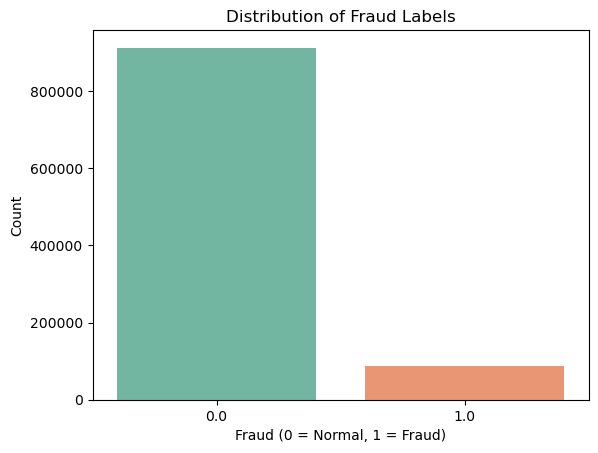

In [7]:
sns.countplot(data=df, x='fraud', hue='fraud', palette='Set2', legend=False)
plt.title("Distribution of Fraud Labels")
plt.xlabel("Fraud (0 = Normal, 1 = Fraud)")
plt.ylabel("Count")
plt.show()

In [8]:
# Split into stratified train and test sets
train_df, test_df = train_test_split(
    df,
    test_size=0.5,
    random_state=42,
    stratify=df["fraud"]
)

In [9]:
# Save the split datasets
save_splits = True 
output_dir = "C:/Users/hp/Desktop/bitirme_projesi"
if save_splits:
    train_path = os.path.join(output_dir, "card_transdata_part1.csv")
    test_path = os.path.join(output_dir, "card_transdata_part2.csv")

    train_df.to_csv(train_path, index=False)
    test_df.to_csv(test_path, index=False)

    print("\nStratified split completed and files saved.")
    print(f"Train set path: {train_path}")
    print(f"Test set path:  {test_path}")


Stratified split completed and files saved.
Train set path: C:/Users/hp/Desktop/bitirme_projesi\card_transdata_part1.csv
Test set path:  C:/Users/hp/Desktop/bitirme_projesi\card_transdata_part2.csv


In [10]:
# Display class distribution of the 'fraud' column
print("\n--- FRAUD Class Distribution ---")

print("\n[Train Set - Part 1]")
print(train_df["fraud"].value_counts(normalize=True))
print(train_df["fraud"].value_counts())

print("\n[Test Set - Part 2]")
print(test_df["fraud"].value_counts(normalize=True))
print(test_df["fraud"].value_counts())


--- FRAUD Class Distribution ---

[Train Set - Part 1]
fraud
0.0    0.912596
1.0    0.087404
Name: proportion, dtype: float64
fraud
0.0    456298
1.0     43702
Name: count, dtype: int64

[Test Set - Part 2]
fraud
0.0    0.912598
1.0    0.087402
Name: proportion, dtype: float64
fraud
0.0    456299
1.0     43701
Name: count, dtype: int64


In [11]:
# Gürültü temizlenecek sütunlar
columns = [
    'distance_from_home',
    'distance_from_last_transaction',
    'ratio_to_median_purchase_price'
]

# Sadece normal işlemleri seç
train_normal = train_df[train_df['fraud'] == 0.0]

# IQR ile outlier temizleme fonksiyonu
def remove_outliers_iqr(df, cols):
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower) & (df[col] <= upper)]
    return df

# Gürültü temizliği
train_normal_clean = remove_outliers_iqr(train_normal, columns)

# Fraud verilerini ekle (onlara dokunmuyoruz)
train_fraud = train_df[train_df['fraud'] == 1.0]

# Temizlenmiş eğitim verisini birleştir
train_cleaned = pd.concat([train_normal_clean, train_fraud], ignore_index=True)

# Sonuç kontrolü
print("Temizlenmiş eğitim verisi şekli:", train_cleaned.shape)
print(train_cleaned['fraud'].value_counts())


Temizlenmiş eğitim verisi şekli: (387743, 8)
fraud
0.0    344041
1.0     43702
Name: count, dtype: int64


In [12]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from collections import Counter

# Separate features and target
X_train = train_cleaned.drop(columns=['fraud'])
y_train = train_cleaned['fraud']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

print("Class distribution before SMOTE:", Counter(y_train))
print("Class distribution after SMOTE:", Counter(y_resampled))




Class distribution before SMOTE: Counter({0.0: 344041, 1.0: 43702})
Class distribution after SMOTE: Counter({0.0: 344041, 1.0: 344041})


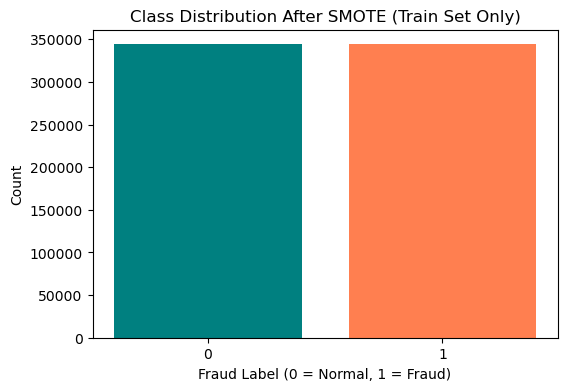

In [13]:
import matplotlib.pyplot as plt
from collections import Counter

counter_res = Counter(y_resampled)

plt.figure(figsize=(6, 4))
plt.bar(counter_res.keys(), counter_res.values(), color=['teal', 'coral'])
plt.title('Class Distribution After SMOTE (Train Set Only)')
plt.xlabel('Fraud Label (0 = Normal, 1 = Fraud)')
plt.ylabel('Count')
plt.xticks([0, 1])
plt.show()



In [14]:
df_smote = pd.DataFrame(X_resampled, columns=X_train.columns)
df_smote['fraud'] = y_resampled

df_smote.to_csv("train_data_smote.csv", index=False)

print(" SMOTE applied data was saved to the file 'train_data_smote.csv'.")
print(df_smote['fraud'].value_counts())


 SMOTE applied data was saved to the file 'train_data_smote.csv'.
fraud
0.0    344041
1.0    344041
Name: count, dtype: int64


In [15]:
from imblearn.under_sampling import TomekLinks
from collections import Counter


X = df_smote.drop(columns=['fraud'])
y = df_smote['fraud']

# Apply Tomek Links
tl = TomekLinks()
X_tomek, y_tomek = tl.fit_resample(X, y)

# Convert the cleaned data back to a DataFrame
df_tomek = pd.DataFrame(X_tomek, columns=X.columns)
df_tomek['fraud'] = y_tomek

# Save the new dataset
df_tomek.to_csv("train_data_smote_tomek.csv", index=False)

# The results
print("Class distribution before Tomek Links:")
print(Counter(y))
print("→ after →")
print(Counter(y_tomek))


Class distribution before Tomek Links:
Counter({0.0: 344041, 1.0: 344041})
→ after →
Counter({0.0: 344041, 1.0: 344041})
